<div style="background-color: #fceaea; padding: 15px; border-left: 5px solid #d9534f;">
<b>Описание задачи</b><br><br>
Сайт запустил A/B тест с целью увеличения дохода. Необходимо проанализировать результаты эксперимента и написать свои рекомендации.<br><br>
<b>Описание датасета</b><br><br>
Исследуемый датасет имеет сырые данные по результатам эксперимента:<br>
1. user_id - уникальный идентификатор пользователя.<br>
2. variant_name - экспериментальная группа.<br>
3. revenue - доход, принесенный пользователем. <br><br>
<b>Ход исследования</b><br><br>
1. Загрузка датасета.<br>
2. Предобработка данных.<br>
3. Статистический анализ (ARPU).<br>
4. Выводы.

In [1]:
import os
import kagglehub
import pandas as pd
import numpy as np
from scipy import stats
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

<div style="background-color: #e6f7ff; padding: 15px; border-left: 5px solid #5bc0de;">
    <b>Загрузка датасета<b>
</div>

In [2]:
# скачиваем датасет из Kaggle - получаем путь к папке
path_folder = kagglehub.dataset_download("sergylog/ab-test-data")

In [3]:
# получаем путь к файлу .csv
for address, dirs, files in os.walk(path_folder):
    for name in files:
        path_file = os.path.join(address, name)

In [4]:
# получаем DataFrame
df = pd.read_csv(path_file)

In [5]:
# переименуем колонки для удобства
df = df.rename(columns={'USER_ID' : 'user_id', 'VARIANT_NAME' : 'variant_name', 'REVENUE' : 'revenue'})

<div style="background-color: #e6f7ff; padding: 15px; border-left: 5px solid #5bc0de;">
<b>Предобработка данных<b>
</div>

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       10000 non-null  int64  
 1   variant_name  10000 non-null  object 
 2   revenue       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


Пропущенные наблюдения отсутствуют, типы данных к переменным указаны корректно.

In [8]:
df.loc[df.duplicated(), :]  # проверка на дубликаты

,user_id,variant_name,revenue
106,7704,control,0.0
195,8406,variant,0.0
224,7042,variant,0.0
302,4409,control,0.0
422,1621,variant,0.0
...,...,...,...
9989,2444,variant,0.0
9993,2400,variant,0.0
9994,3129,control,0.0
9995,1981,control,0.0


In [9]:
df.user_id.nunique()  # проверяем уникальное количество ID пользователей

6324

Судя по описанию задачи, ID пользователей не должны повторяться. 
Необходимо избавиться также от строк, где ID пользователя встречается в обеих группах.

In [10]:
# избавляемся от дубликатов
df_clean = df.loc[~df.duplicated(), :].reset_index(drop=True)
df_multi_user = df_clean.groupby('user_id', as_index=False).agg({'variant_name' : 'nunique'})\
                        .rename(columns={'variant_name' : 'count_group'})\
                        .query('count_group > 1')
df_clean = df_clean[~df_clean['user_id'].isin(df_multi_user['user_id'])].reset_index(drop=True)

In [11]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4821 entries, 0 to 4820
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       4821 non-null   int64  
 1   variant_name  4821 non-null   object 
 2   revenue       4821 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 113.1+ KB


In [12]:
df_clean.groupby('variant_name').agg({'user_id' : 'count'})

,user_id
variant_name,
control,2414
variant,2407


Наблюдения по двум группам сбалансированы.

In [13]:
# сформируем датафремы по группам для удобства
df_control = df_clean[df_clean['variant_name'] == 'control'].reset_index(drop=True)
df_variant = df_clean[df_clean['variant_name'] == 'variant'].reset_index(drop=True)

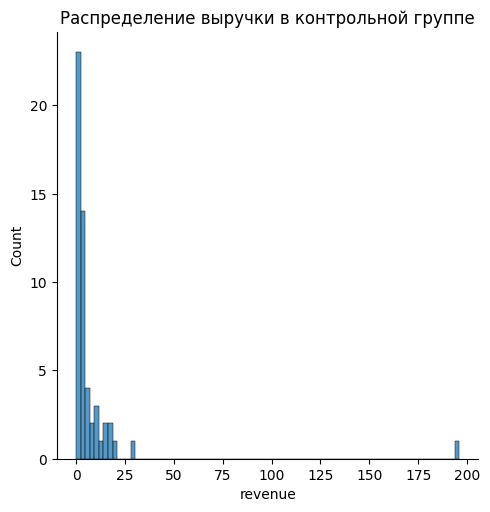

In [14]:
sns.displot(df_control[df_control['revenue'] != 0], x='revenue')
plt.title('Распределение выручки в контрольной группе');

В контрольной группе есть явно какой-то выброс, основная масса наблюдений находится в диапазоне от 0 до 25. Оставим значения только в этом диапазоне для контрольной группы.

In [15]:
df_control = df_control.loc[df_control['revenue'] <= 25]

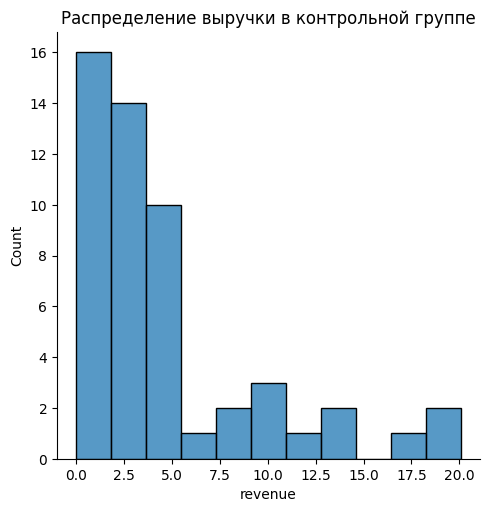

In [16]:
sns.displot(df_control[df_control['revenue'] != 0], x='revenue')
plt.title('Распределение выручки в контрольной группе');

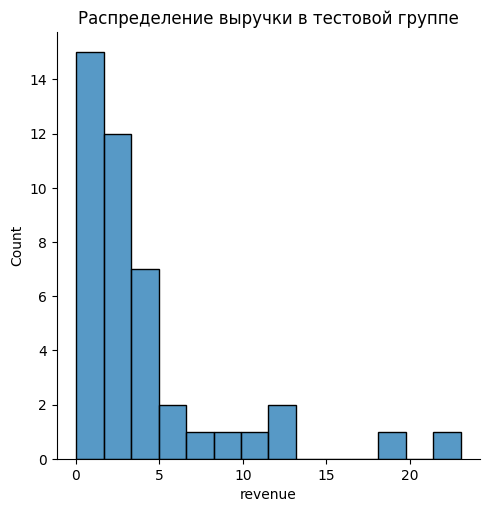

In [17]:
sns.displot(df_variant[df_variant['revenue'] != 0], x='revenue')
plt.title('Распределение выручки в тестовой группе');

<div style="background-color: #e6f7ff; padding: 15px; border-left: 5px solid #5bc0de;">
<b>Статистический анализ (ARPU)<b>
</div>

* H0: μ1 = μ2 (среднее в контрольной и тестовой группах одинаковы).
* H1: μ1 != μ2 (среднее в контрольной и тестовой группах отличаются).

In [18]:
print(f'Среднее в контрольной группе: {df_control.revenue.mean()}')
print(f'Среднее в тестовой группе: {df_variant.revenue.mean()}')

Среднее в контрольной группе: 0.10167081260364844
Среднее в тестовой группе: 0.07449937681761529


##### тест Шапиро-Уилка 
* H0: выборка распределена по нормальному закону.
* H1: закон распределения не является нормальным.

In [19]:
stats.shapiro(df_control.revenue)

ShapiroResult(statistic=np.float64(0.07867252753631404), pvalue=np.float64(1.5463825242491196e-75))

In [20]:
stats.shapiro(df_variant.revenue)

ShapiroResult(statistic=np.float64(0.061301809078948666), pvalue=np.float64(7.176271233342271e-76))

Для обеих групп отклоняется нулевая гипотеза о нормальном распределении. 

##### тест Левена
* H0: дисперсии в выборках не имеют значимых различий.
* H1: дисперсии в выборках имеют значимые различия.

In [21]:
stats.levene(df_control['revenue'], df_variant['revenue'], center='mean')

LeveneResult(statistic=np.float64(4.049572481226208), pvalue=np.float64(0.04423809185200269))

Дисперсии в контрольной и тестовой группах различаются, нулевая гипотеза отклоняется.

В результате имеем: распределение в группах отличается от нормального, дисперсии гетерогенны. Предположение о нормальном распределении не выполянется для применения t-критерия. Критерий Манна-Уитни не подходит ввиду того, что он становится менее чувствительным на повторяющихся данных. Будем использовать: t-критерий Уэлча и bootstrap.

##### A/A-test

Воспользуемся симуляцией для оценки вероятности ошибки первого рода в контексте статистического теста Уэлча.

In [22]:
sample_size = 0.9
n_samples = 10000

sub_sample_size = int(sample_size*np.size(df_control.revenue.values))

res_p_values = []

for _ in tqdm(range(n_samples)):
    group1 = np.random.choice(df_control.revenue.values, size=sub_sample_size, replace=False, p=None)
    group2 = np.random.choice(df_control.revenue.values, size=sub_sample_size, replace=False, p=None)

    stat_test = stats.ttest_ind(group1, group2, equal_var=False)
    p_value = stat_test.pvalue
    res_p_values.append(p_value)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1239.13it/s]


In [23]:
# оставляем только p-value <= 0.05
f_p = list(filter(lambda x: x <= 0.05, res_p_values))
f_p_count = len(f_p)

# частота ложных положительных результатов
fpr = f_p_count / sub_sample_size

In [24]:
fpr

0.0

Исходя из величины False Positive Rate, в ходе симуляции p-values оказались меньше либо равны заданному порогу 0.05.

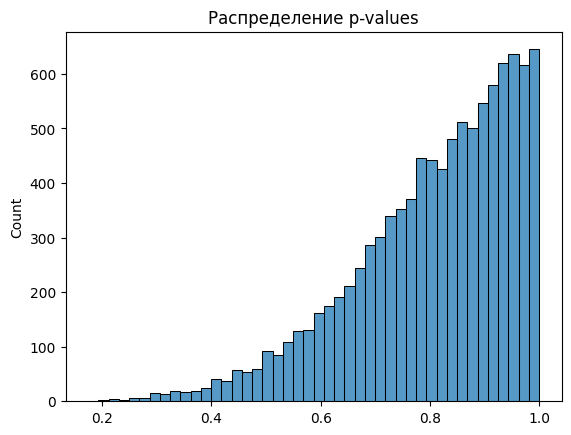

In [25]:
sns.histplot(res_p_values)
plt.title('Распределение p-values');

##### Bootstrap

In [26]:
# сохраняем в список разницу между средними в группах
mean_diff = []

for i in tqdm(range(10000)):
    sample_data_control = df_control.sample(frac=1, replace=True)
    sample_mean_control = sample_data_control.revenue.mean()

    sample_data_variant = df_variant.sample(frac=1, replace=True)
    sample_mean_variant = sample_data_variant.revenue.mean()

    sample_mean_diff = sample_mean_control - sample_mean_variant
    mean_diff.append(sample_mean_diff)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4151.27it/s]


In [27]:
lower_q = pd.Series(mean_diff).quantile(0.025)
upper_q = pd.Series(mean_diff).quantile(0.975)

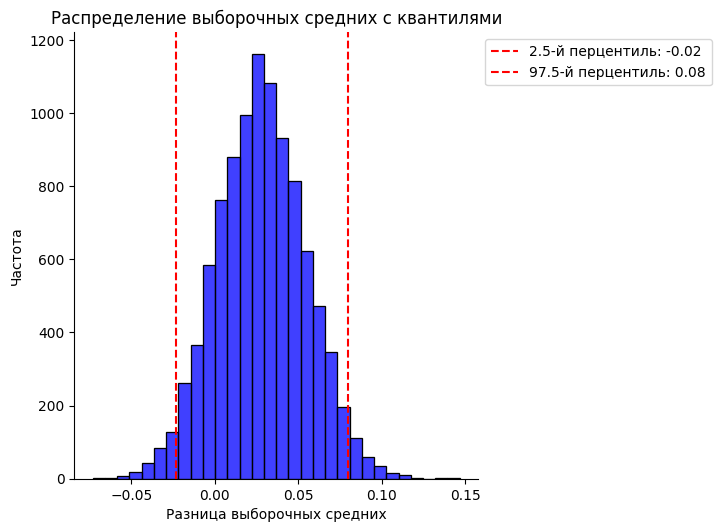

In [28]:
sns.displot(mean_diff, bins=30, color='blue')
# добавление линий квантилей
plt.axvline(lower_q, color='red', linestyle='--', label=f'2.5-й перцентиль: {lower_q:.2f}')
plt.axvline(upper_q, color='red', linestyle='--', label=f'97.5-й перцентиль: {upper_q:.2f}')

# добавление легенды и подписей
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Распределение выборочных средних с квантилями')
plt.xlabel('Разница выборочных средних')
plt.ylabel('Частота')
plt.show();

Доверительный интервал содержит 0, следовательно, нулевая гипотеза не отклоняется.

<div style="background-color: #e6f7ff; padding: 15px; border-left: 5px solid #5bc0de;">
<b>Выводы<b>
</div>

Проведенный анализ показал, что различий в среднем доходе на пользователя (ARPU) в контрольной и тестовой группах нет. Внедренное изменение не оказало значимого влияния на доход сайта.